In [1]:
import matplotlib.pyplot as plt
import import_ipynb
from Model import GoogLeNetV1
from Model_add_bn import InceptionV1
import tensorflow as tf
import json
import os
import time
import glob
import random
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

importing Jupyter notebook from Model.ipynb
importing Jupyter notebook from Model_add_bn.ipynb


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(True) # 把各个变量分布在哪个gpu上打印出来
logical_gpus = tf.config.experimental.list_physical_devices('GPU')
print(logical_gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True) # 内存自增长
            

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [26]:
data_root = os.path.abspath(os.path.join(os.getcwd(),"../../datasets"))
image_path = data_root+"/flower_data/"
train_dir = image_path+'train'
validation_dir = image_path+'val'

if not os.path.exists('save_weights'):
    os.mkdir('save_weights')
im_height=224
im_width =224
batch_size=32
epochs = 30

In [4]:
data_class = [cla for cla in os.listdir(train_dir) if '.txt' not in cla]
class_num = len(data_class)

In [5]:
class_dict = dict((value,index) for index,value in enumerate(data_class))

In [6]:
inverse_dict = dict((val, key) for key, val in class_dict.items())
# write dict into json file
json_str = json.dumps(inverse_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

In [7]:
# load train images list
train_image_list = glob.glob(train_dir + "/*/*.jpg")
random.shuffle(train_image_list)
train_num = len(train_image_list)
train_label_list = [class_dict[path.split(os.path.sep)[-2]] for path in train_image_list]

In [8]:
# load validation images list
val_image_list = glob.glob(validation_dir + "/*/*.jpg")
random.shuffle(val_image_list)
val_num = len(val_image_list)
val_label_list = [class_dict[path.split(os.path.sep)[-2]] for path in val_image_list]

In [9]:
def process_train_img(img_path, label):
    label = tf.one_hot(label, depth = class_num)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [im_height, im_width])
    image = tf.image.random_flip_left_right(image)
    image = (image - 0.5) / 0.5
    return image, label

In [10]:
def process_val_img(img_path, label):
    label = tf.one_hot(label, depth = class_num)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [im_height, im_width])
    image = (image - 0.5) / 0.5
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
# load train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_list, train_label_list))
train_dataset = train_dataset.shuffle(buffer_size = train_num)\
    .map(process_train_img, num_parallel_calls = AUTOTUNE)\
    .repeat().batch(batch_size).prefetch(AUTOTUNE)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [13]:
# load train dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_list, val_label_list))
val_dataset = val_dataset.map(process_val_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)\
    .repeat().batch(batch_size)

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [14]:
model = InceptionV1(im_height=im_height,im_width=im_width,class_num=5,aux_logits=True)
# model.build((batch_size,224,224,3)) # subclass model
model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [28]:
logdir = './callbacks'
import datetime
if not os.path.exists(logdir):
    os.mkdir(logdir)
print(train_dataset)
# log_dir= logdir +datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer=tf.summary.create_file_writer(logdir)
tf.summary.trace_on(graph=True, profiler=True)

<PrefetchDataset shapes: ((None, 224, 224, None), (None, 5)), types: (tf.float32, tf.float32)>


In [29]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        aux1, aux2, output = model(images, training=True)
        loss1 = loss_object(labels, aux1)
        loss2 = loss_object(labels, aux2)
        loss3 = loss_object(labels, output)
        loss = loss1 * 0.3 + loss2 * 0.3 + loss3
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, output)

@tf.function
def test_step(images, labels):
    _, _, output = model(images, training=False)
    t_loss = loss_object(labels, output)

    test_loss(t_loss)
    test_accuracy(labels, output)

best_test_loss = float('inf')
train_step_num = train_num // batch_size
val_step_num = val_num // batch_size

# 保留结果用于绘制
train_loss_results = []
train_accuracy_results = []
test_loss_results = []
test_accuracy_results = []


for epoch in range(1, epochs+1):
    train_loss.reset_states()        # clear history info
    train_accuracy.reset_states()    # clear history info
    test_loss.reset_states()         # clear history info
    test_accuracy.reset_states()     # clear history info

    t1 = time.perf_counter()
    for index, (images, labels) in enumerate(train_dataset):
        # 将图片写入tensorboard
        with summary_writer.as_default():
            tf.summary.image('Training data', images, max_outputs=5, step=0)
            
        train_step(images, labels)
        if index+1 == train_step_num:
            break
    print(time.perf_counter()-t1)

    for index, (images, labels) in enumerate(val_dataset):
        test_step(images, labels)
        if index+1 == val_step_num:
            break
    
    with summary_writer.as_default():  # 将loss写入TensorBoard
        tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
    with summary_writer.as_default():  # 将acc写入TensorBoard
        tf.summary.scalar('test_acc', test_accuracy.result(), step=epoch)
            
    # 循环结束
    train_loss_results.append(train_loss.result())
    train_accuracy_results.append(train_accuracy.result())
    test_loss_results.append(test_loss.result())
    test_accuracy_results.append(test_accuracy.result())

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))
    
    if test_loss.result() < best_test_loss:
        model.save_weights("./save_weights/myGoogLeNet.ckpt".format(epoch), save_format='tf')
        

summary_writer.close()

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

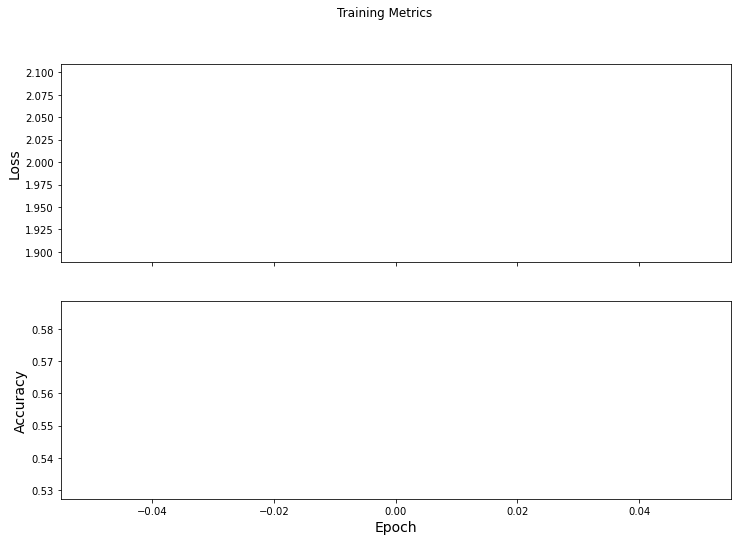

In [23]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [24]:
import pydot

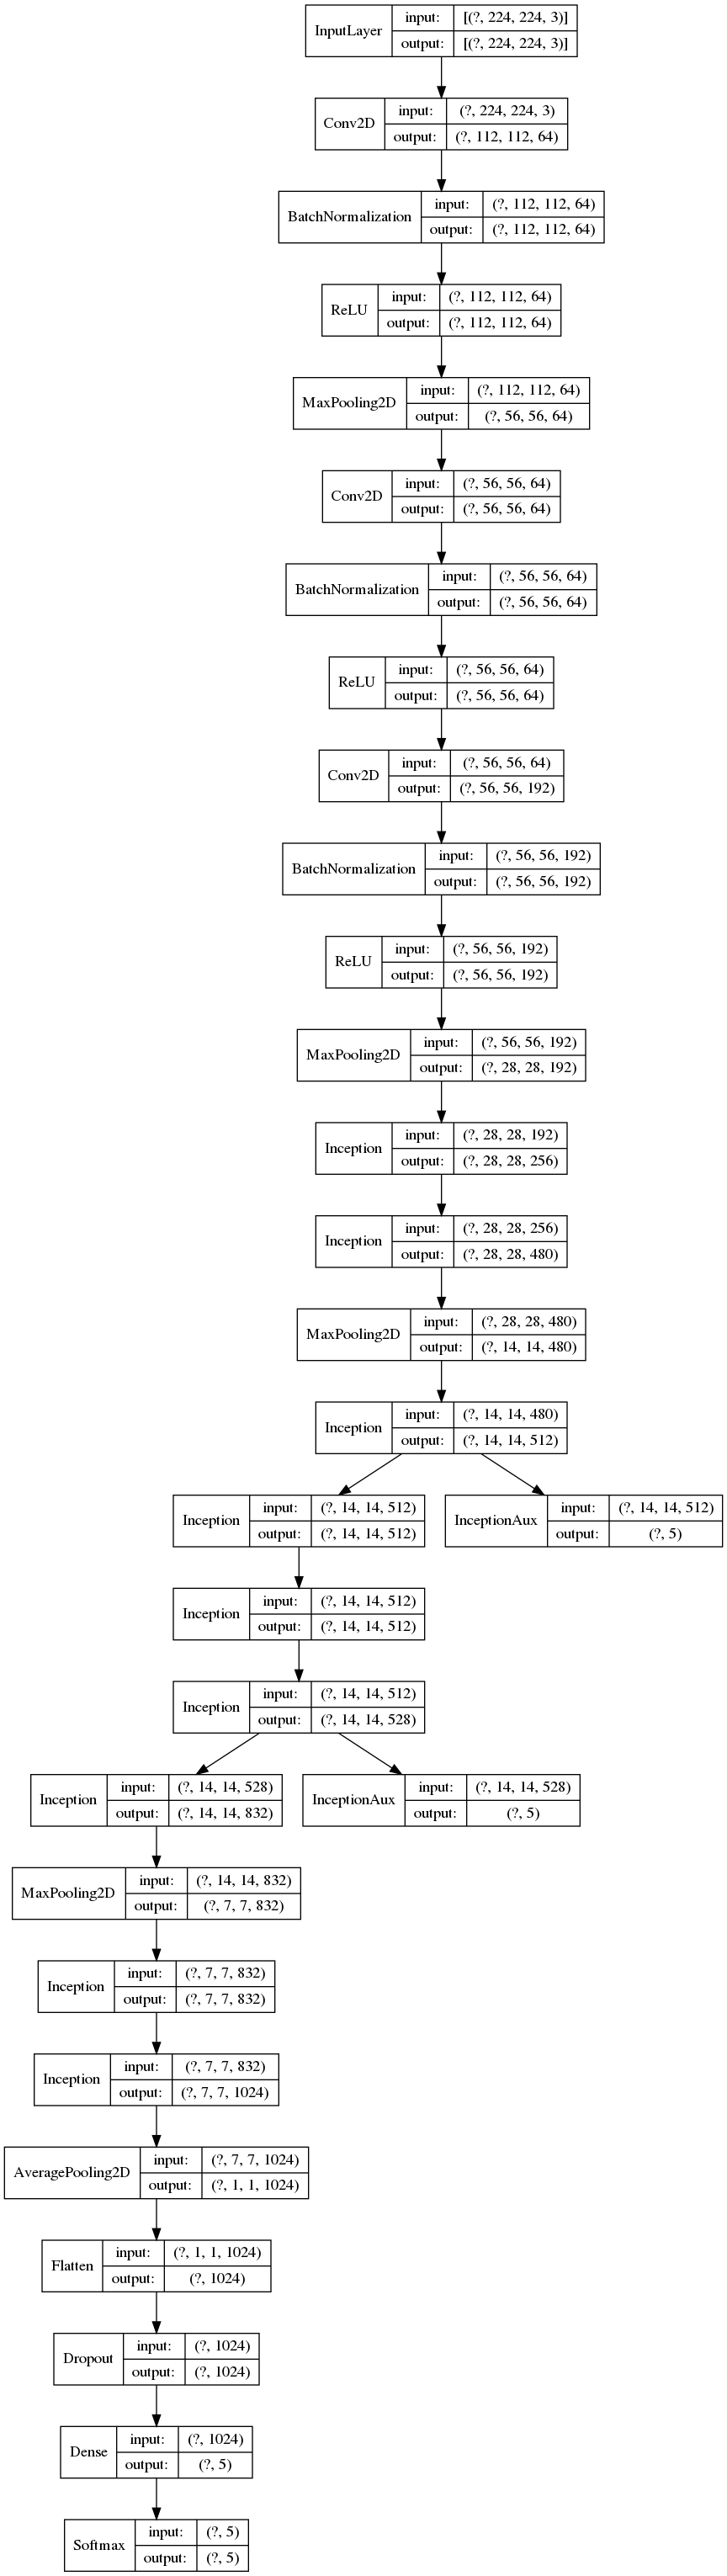

In [25]:
tf.keras.utils.plot_model(model,show_layer_names=False,show_shapes=True)